In [1]:
# Disable multithreading to avoid memory leak
import os
os.environ["OMP_NUM_THREADS"] = "1"  

## Importing Libraries

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Evaluation
from sklearn.metrics import silhouette_score


## Loading the dataset

In [32]:
# Loading the data
df = pd.read_csv(r"C:\Users\Admin\Documents\GitHub\Mall_Customers_Segmentation\Mall_Customers_Segmentation\Mall_Customers.csv")
df.head

<bound method NDFrame.head of      CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196  Female   35                 120                      79
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83

[200 rows x 5 columns]>

_____________________________________
### Columns Description

- CustomerID: A unique identifier for each customer (integer).
- Genre: The gender of the customer (Male/Female).
- Age: The age of the customer (integer).
- Annual Income (k$): Annual income of the customer in thousands of dollars (integer).
- Spending Score (1-100): A score assigned by the mall based on customer behavior and spending patterns (integer).
_____________________________________

## 1. Data Exploration & Preprocessing

In [33]:
# Checking for missing values
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

No missing values.

In [34]:
# Checking for duplicates
df.duplicated().sum()

0

No duplicated rows.

In [35]:
#Checking datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [36]:
# Dropping unnecessary column for our work
df = df.drop("CustomerID", axis=1)

In [37]:
# Basic statistics of the dataset
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


### Interpretation:
The dataset consists of 200 customers with information on their age, annual income, and spending score. The average age of customers is approximately 38.85 years, with ages ranging from 18 to 70, indicating that the mall serves a broad age group. However, half of the customers fall between the ages of 28.75 and 49, suggesting that middle-aged adults form a significant portion of the customer base.

The annual income varies widely, with an average of about 60.56k and a range from 15k to 137k. The income distribution shows that 25% of the customers earn below 41.5k, while the top 25% earn above 78k, highlighting the presence of both low and high-income groups. This diversity in income levels may influence purchasing power and spending behavior.

The spending score, which reflects customer purchasing behavior on a scale from 1 to 100, also exhibits high variability. The average spending score is 50.2, with scores ranging from 1 to 99. This indicates that some customers are very conservative in their spending, while others are heavy spenders. The interquartile range (34.75 to 73) shows that the majority of customers cluster around the middle of the spending scale, with a balanced mix of moderate and high-spending individuals.

Overall, the dataset displays considerable variability across all three key features — age, income, and spending — making it suitable for clustering. These patterns suggest that there may be distinct customer segments based on demographic and behavioral traits, which unsupervised learning techniques like K-Means and hierarchical clustering can help uncover.

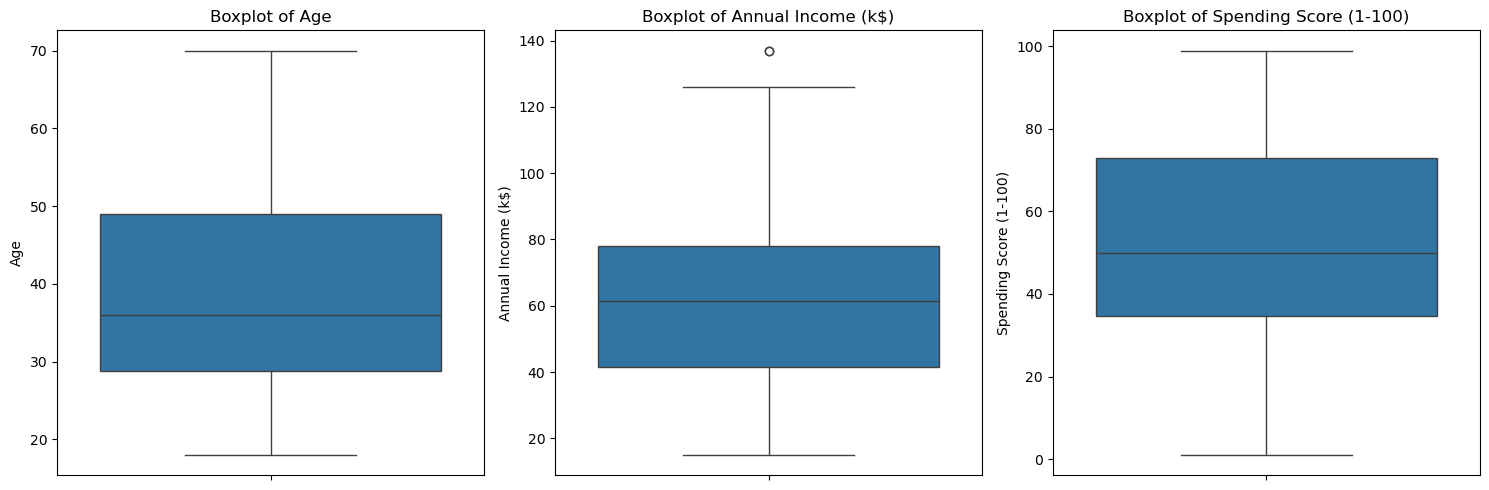

In [8]:
# Checking for outliers
# Set up the layout
plt.figure(figsize=(15, 5))

features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Loop through numerical features
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


One mild outlier was observed in the Annual Income feature, but it was retained as it does not significantly distort the scale.

### Transforming the data (Scaling)

In [9]:
# Select only the numerical features
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(df[features])

# Convert back to DataFrame for readability
scaled_df = pd.DataFrame(scaled_data, columns=features)

# Show the scaled data
scaled_df.head()


,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


### Pair plots to understand relationships between features.

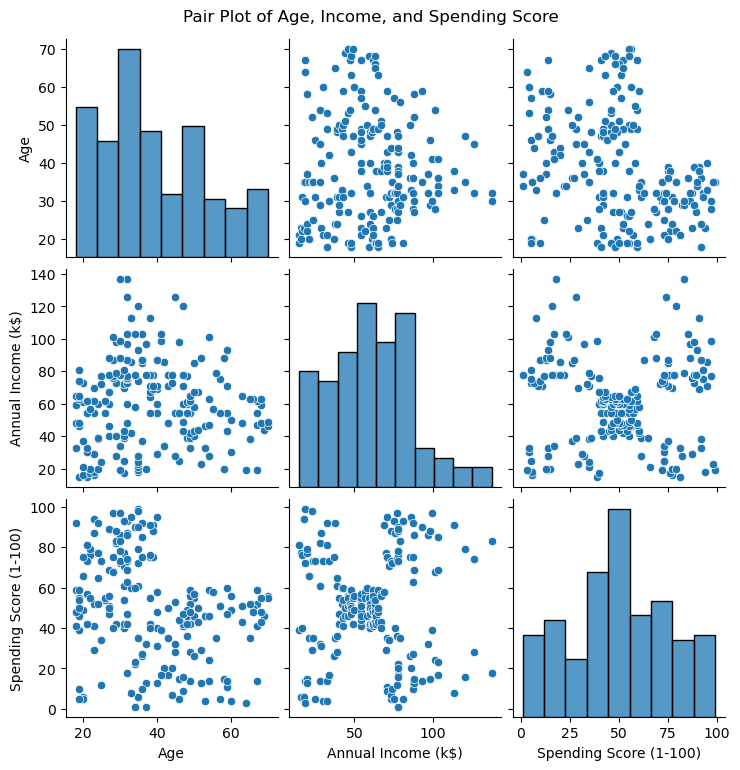

In [10]:
# Creating pair plot of the original numerical features
sns.pairplot(df[features])
plt.suptitle("Pair Plot of Age, Income, and Spending Score", y=1.02)
plt.show()

Interpretation:
The pair plot visualizes relationships between Age, Annual Income, and Spending Score:
1. Age vs. Annual Income:
   - Likely a weak or nonlinear correlation. Younger and older customers may have lower incomes, while middle-aged customers show variability.

2. Age vs. Spending Score:
   - Potential negative trend: Younger customers might have higher spending scores, while older customers spend less. However, the bimodal distribution of spending scores complicates this.

3. Annual Income vs. Spending Score:
   - Possible clusters or segments (e.g., high-income moderate spenders vs. middle-income high spenders). This suggests that income alone doesn’t dictate spending behavior.

Key Insight: The lack of strong linear relationships highlights the need for segmentation (e.g., clustering analysis) to tailor strategies for distinct customer profiles (e.g., "High-Income Conservatives" vs. "Middle-Income Big Spenders").

###  Histograms to view the distribution of the data.

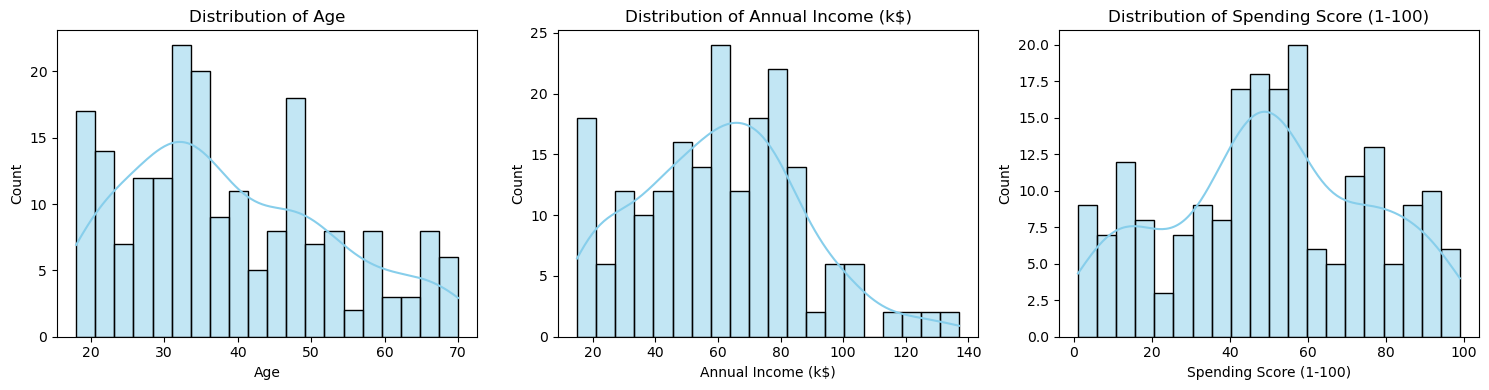

In [11]:
# Set figure size
plt.figure(figsize=(15, 4))

# Plot a histogram for each feature
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

**Interpretation:** The histograms illustrate the distribution of each variable individually:
1. Distribution of Age
    - Shape: The distribution appears to be slightly right-skewed, with a peak around the 30-40 age range.
    - Central Tendency: Most customers are between 30 and 50 years old, with fewer customers in the younger (20-30) and older (60-70) age groups.
    - Indicates: The mall's primary customer base is middle-aged, suggesting that marketing strategies could target this demographic more effectively.

2. Distribution of Annual Income (k$)
    - Shape: The distribution is roughly normal with a slight right skew, peaking around 65k and 75k.
    - Central Tendency: The majority of customers earn between 45k and 80k annually, with fewer individuals at the extremes (<20k or >120k).
    - Indicates: The mall caters predominantly to middle-income earners. Luxury brands or budget-friendly options may need tailored strategies to attract higher or lower-income segments.

3. Distribution of Spending Score (1-100)
    - Shape: The distribution is bimodal, with peaks around 40-60.
    - Central Tendency: Customers cluster into two groups—moderate spenders and high spenders. Few customers have very low or very high scores.
    - Indicates: The mall may have distinct customer segments (e.g., casual shoppers vs. enthusiastic spenders). Personalized promotions could enhance engagement for each group.



##  2. K-Means Clustering

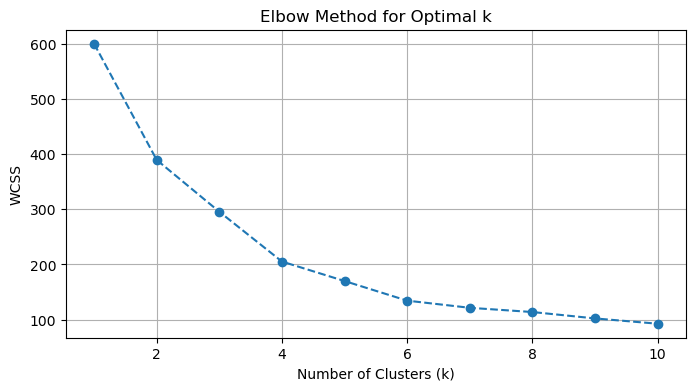

In [12]:
# Elbow Method to find optimal k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)  # WCSS = Within-Cluster Sum of Squares

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.grid()
plt.show()


    - The biggest drops in WCSS are between k = 1 and k = 3

    - After k = 5, the decrease becomes much more gradual

 Optimal k = 5 is the best choice - it’s the point where adding more clusters starts to yield diminishing returns in reducing WCSS. At this point, the WCSS shows a significant reduction compared to previous values, but further increases in k beyond 5 result in minimal improvement. This suggests that the customer data can be effectively grouped into five distinct segments.

In [13]:
# Fit K-Means with optimal k 
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_df)

# Add cluster labels to the original data
df["Cluster"] = clusters
print(df.head())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster  
0        2  
1        2  
2        3  
3        2  
4        2  


### Interpreting the characteristics of each cluster.

In [14]:
# Get cluster characteristics
df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()


,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,55.275862,47.620690,41.706897
1,32.875000,86.100000,81.525000
2,25.769231,26.115385,74.846154
3,26.733333,54.311111,40.911111
4,44.387097,89.774194,18.483871


### Interpretation:

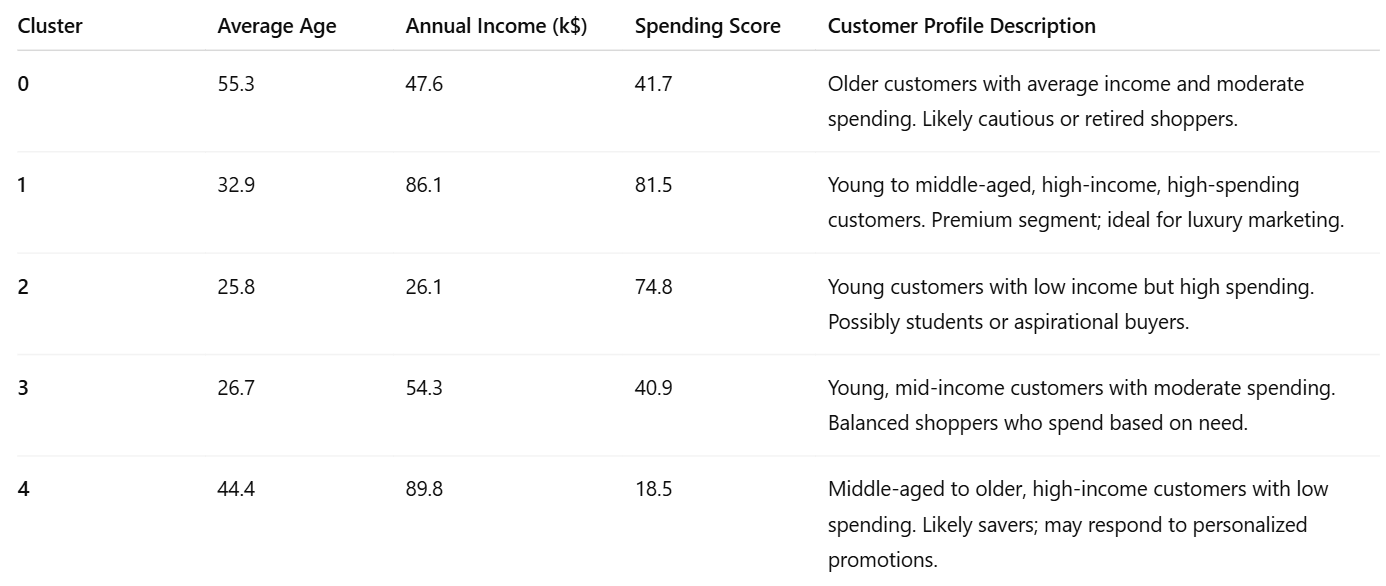

### Visualizing the clusters

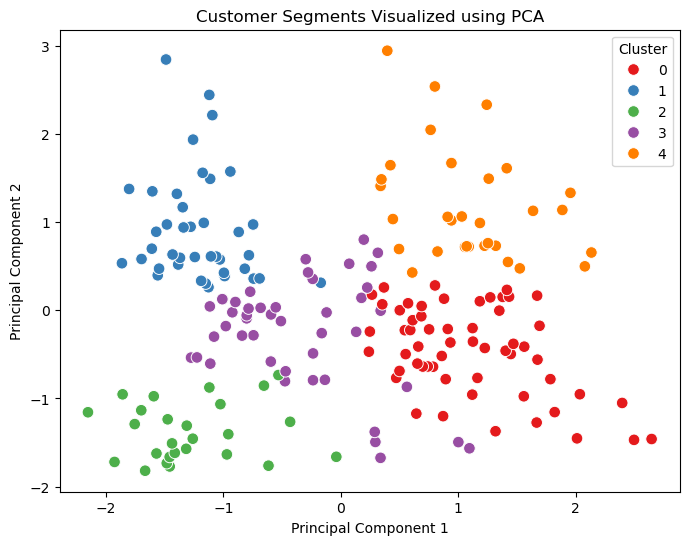

In [15]:
# Reduce to 2D for plotting
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=70)
plt.title('Customer Segments Visualized using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

**What It Shows:**
- The plot displays customer clusters reduced to 2 principal components (PC1 and PC2) for simplicity.
- Each point represents a customer, colored by their cluster assignment.

**Business Implication:**
- PCA helps visualize complex data in 2D, confirming that the clustering captures meaningful patterns.

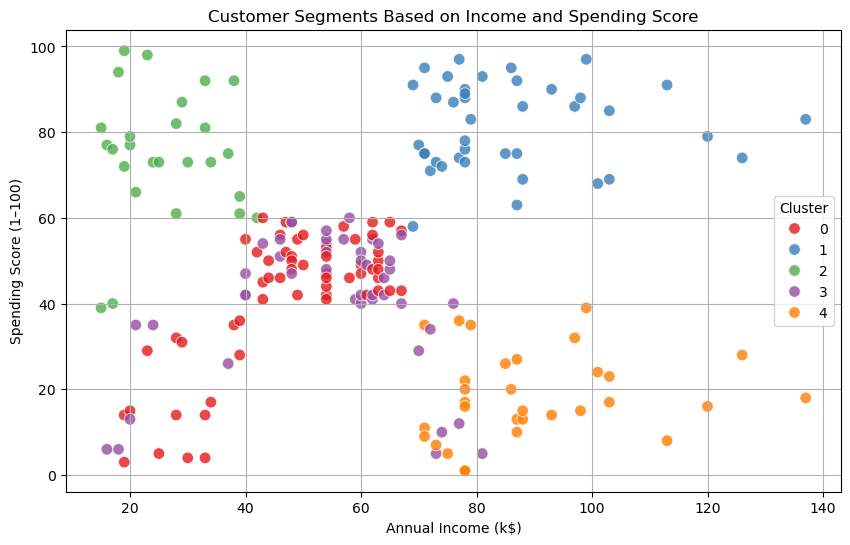

In [16]:
# Scatter plot using original features
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='Annual Income (k$)', 
    y='Spending Score (1-100)', 
    hue='Cluster', 
    palette='Set1', 
    s=70, 
    alpha=0.8
)
plt.title("Customer Segments Based on Income and Spending Score")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1–100)")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**What It Shows:**
 - X-axis: Annual Income (k$).
 - Y-axis: Spending Score (1–100).
 - Colors: Represent different clusters (0–4).

**Key Insights:**
 - High Income + High Spending (Top Right): Prime customers (Cluster 1).
 - Low Income + High Spending (Top Left): Budget shoppers (Cluster 2).
 - Low Spending (Bottom Half): Less engaged customers (Clusters 0, 3, or 4).

**Business Implication:**
 - Target High Spenders: Loyalty programs for top-right clusters.
 - Re-engage Low Spenders: Discounts for bottom-left clusters.

## 3. Hierarchical Clustering

In [18]:
# Initialize
linkage_methods = ['ward', 'average', 'complete']
results = []

# Test each method
for method in linkage_methods:
    model = AgglomerativeClustering(n_clusters=5, linkage=method)
    labels = model.fit_predict(scaled_df)
    
    # Store results
    silhouette = silhouette_score(scaled_df, labels)
    cluster_stats = df.groupby(labels)[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
    
    results.append({
        'Method': method,
        'Silhouette': silhouette,
        'Clusters': cluster_stats
    })

# Print summary
for result in results:
    print(f"\nMethod: {result['Method'].upper()}")
    print(f"Silhouette Score: {result['Silhouette']:.2f}")
    print("Cluster Means:")
    display(result['Clusters'].round(2))


Method: WARD
Silhouette Score: 0.39
Cluster Means:


,Age,Annual Income (k$),Spending Score (1-100)
0,26.56,47.36,56.79
1,56.40,55.29,48.36
2,32.69,86.54,82.13
3,43.89,91.29,16.68
4,44.32,25.77,20.27



Method: AVERAGE
Silhouette Score: 0.41
Cluster Means:


,Age,Annual Income (k$),Spending Score (1-100)
0,41.69,88.23,17.29
1,24.65,42.94,62.08
2,43.90,24.45,19.10
3,32.69,86.54,82.13
4,53.26,54.20,48.56



Method: COMPLETE
Silhouette Score: 0.40
Cluster Means:


,Age,Annual Income (k$),Spending Score (1-100)
0,28.35,50.29,45.94
1,41.69,88.23,17.29
2,55.33,47.32,41.09
3,32.69,86.54,82.13
4,24.81,25.62,80.24


**Interpretation:**

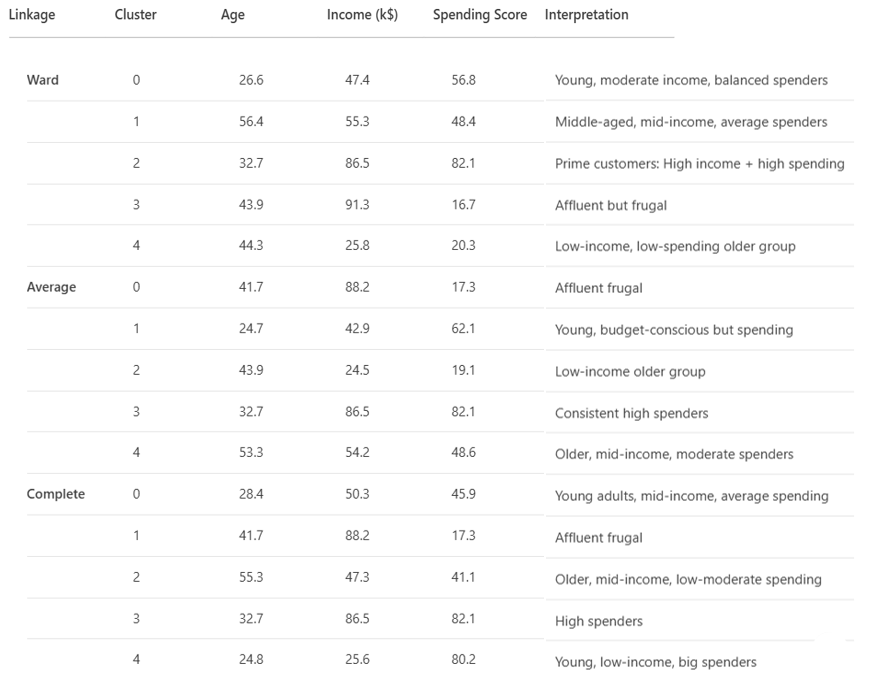

###  Creating a dendrogram to visualize the hierarchical clustering results.

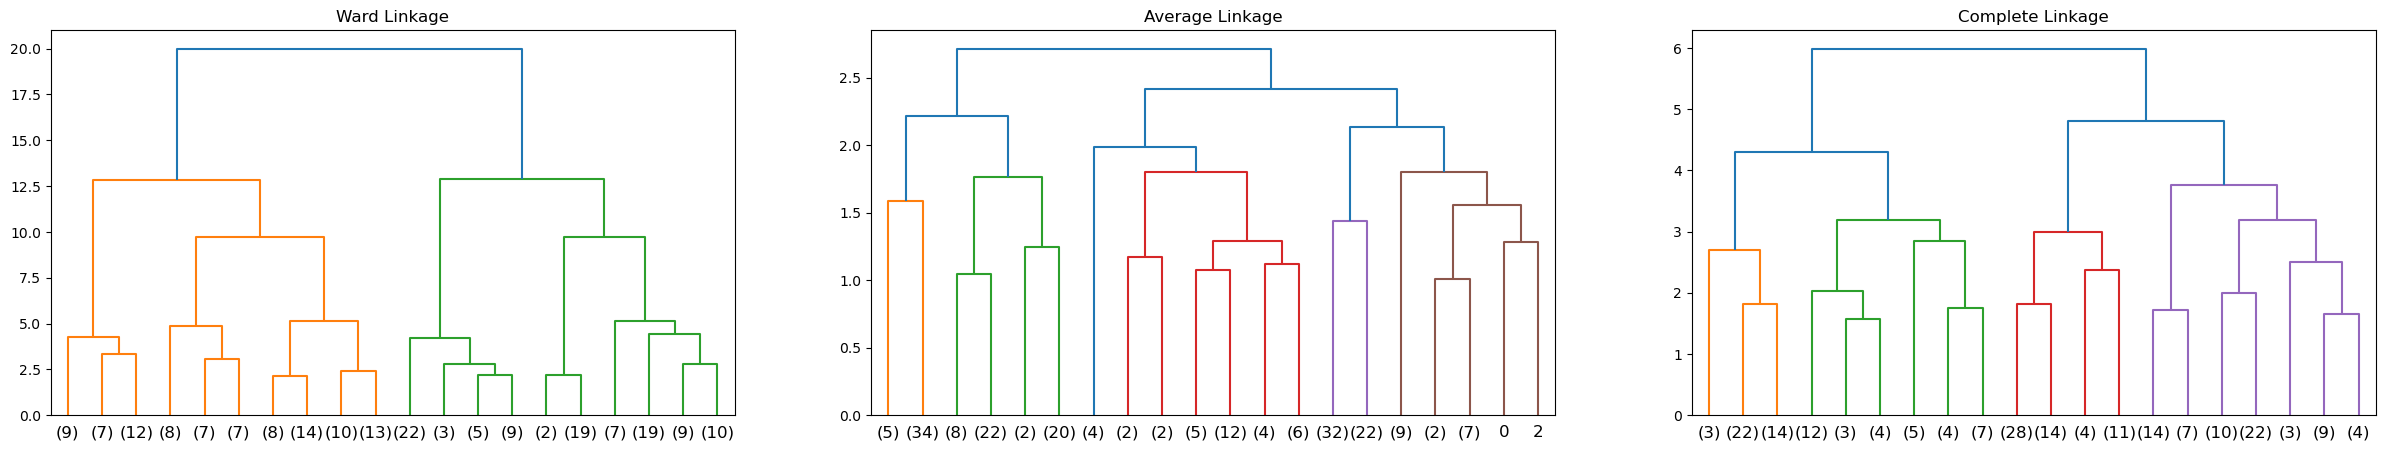

In [20]:
plt.figure(figsize=(30, 5))  
for i, method in enumerate(linkage_methods):  
    Z = linkage(scaled_df, method=method)  
    plt.subplot(1, 3, i+1)  
    dendrogram(Z, truncate_mode='lastp', p=20)  
    plt.title(f"{method.capitalize()} Linkage")  
plt.show()  

### *Comparison of Linkage Methods (Based on Dendrograms)*


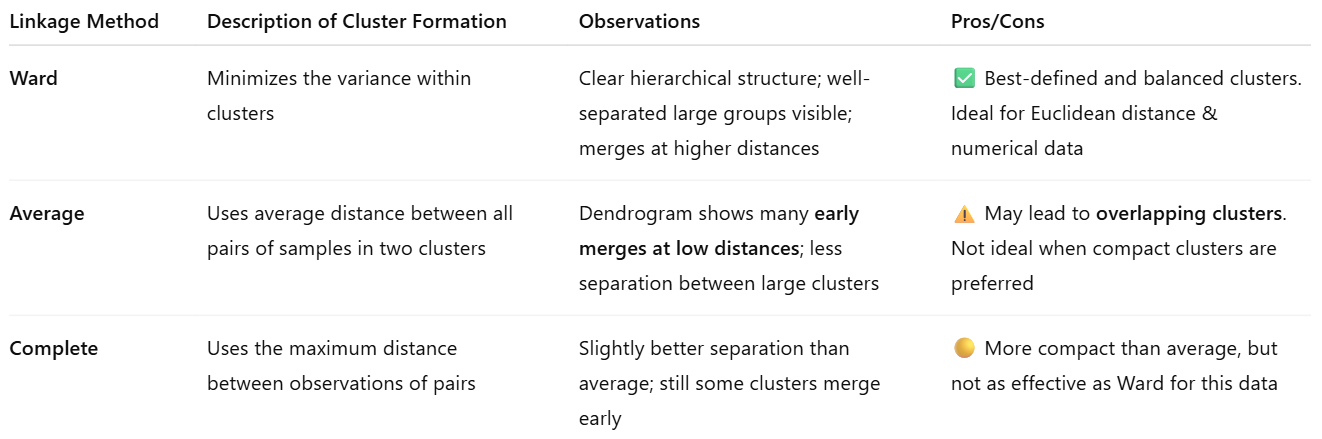

In [21]:
# Try linkage methods
linkage_methods = ['ward', 'average', 'complete']
for method in linkage_methods:
    model = AgglomerativeClustering(n_clusters=5, linkage=method)
    clusters = model.fit_predict(scaled_df)
    print(f"Linkage: {method}, Silhouette Score: {silhouette_score(scaled_df, clusters):.2f}")

Linkage: ward, Silhouette Score: 0.39
Linkage: average, Silhouette Score: 0.41
Linkage: complete, Silhouette Score: 0.40


________________________________________________________________
###  Which linkage method produces the best results?

- Based on both the dendrogram structure and the silhouette scores, the Ward linkage method produces the best overall results.

- Although Average linkage gave the highest silhouette score (0.41), its clusters were less interpretable and showed poor separation in the dendrogram. In contrast, Ward linkage produced a well-structured dendrogram with clearly defined and compact clusters, and still achieved a reasonably high silhouette score (0.39).

- Therefore, Ward linkage is the most balanced and effective method, offering both good clustering quality and meaningful cluster interpretation.
__________________________________________________________________


## How do the clusters formed using hierarchical clustering differ from K-Means?

The clusters formed using hierarchical clustering differ from K-Means in both structure and flexibility:

1. Clustering Approach:

- K-Means:

    - Partition-based: Divides data into k clusters by minimizing distances to centroids.
    - Assumes spherical clusters of roughly equal size (due to centroid optimization).

- Hierarchical (Agglomerative):
    - Builds a dendrogram: Starts with each point as its own cluster and merges closest pairs iteratively.
    - No centroid assumption: Uses linkage methods (ward, average, complete) to measure distances between clusters.

2. Cluster Shape:

- K-Means: Rigidly produces hyper-spherical clusters (may fail for elongated or irregular shapes).

- Hierarchical (Agglomerative): Captures arbitrary shapes (e.g., average linkage can handle nested clusters, complete is robust to outliers).

3. Flexibility in choosing K:

- In K-Means, the number of clusters k must be set in advance.
- In hierarchical clustering, we can choose the number of clusters by cutting the dendrogram at a certain height, making it more flexible for exploration.

4. Result Comparison:

- In this dataset, K-Means gave more distinct and clearly separated clusters, especially when visualized in 2D.
- Hierarchical clustering (Ward linkage) also formed meaningful groups but sometimes merged closer clusters together due to its top-down nature.

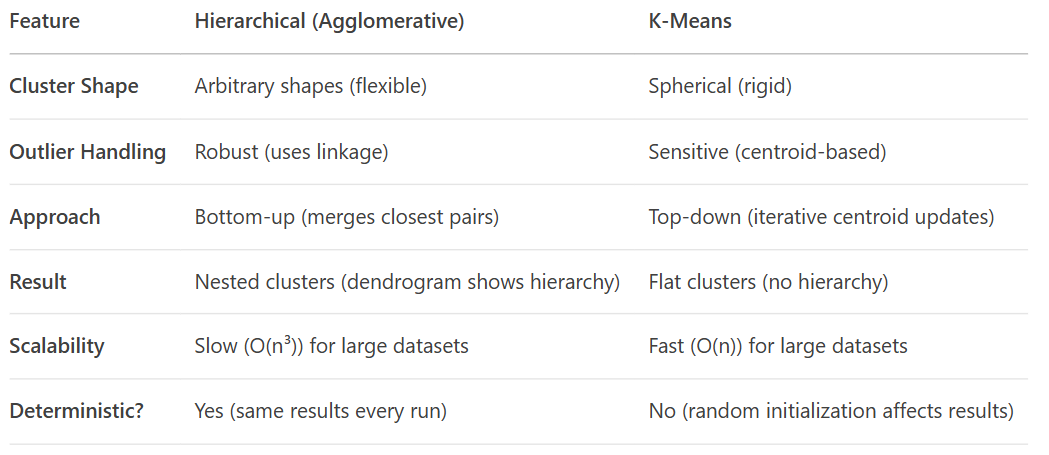




## 4. Dimensionality Reduction (PCA)

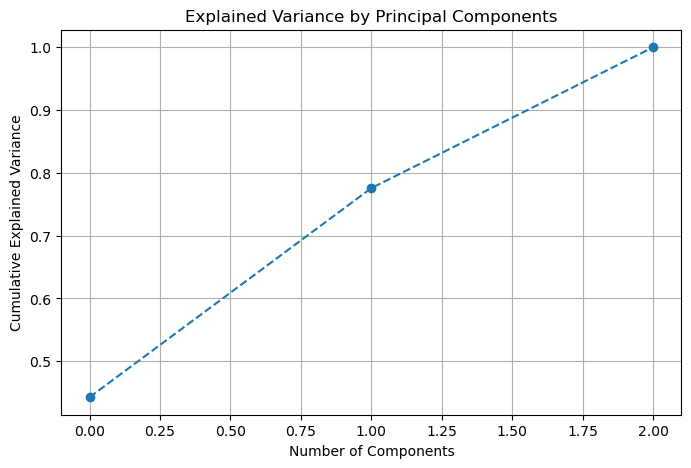

PC1: 44.27%
PC2: 33.31%
PC3: 22.43%


In [22]:
# Perform PCA on the scaled data
pca = PCA()
pca_components = pca.fit_transform(scaled_df)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Print individual explained variance
for i, var in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"PC{i+1}: {var:.2%}")


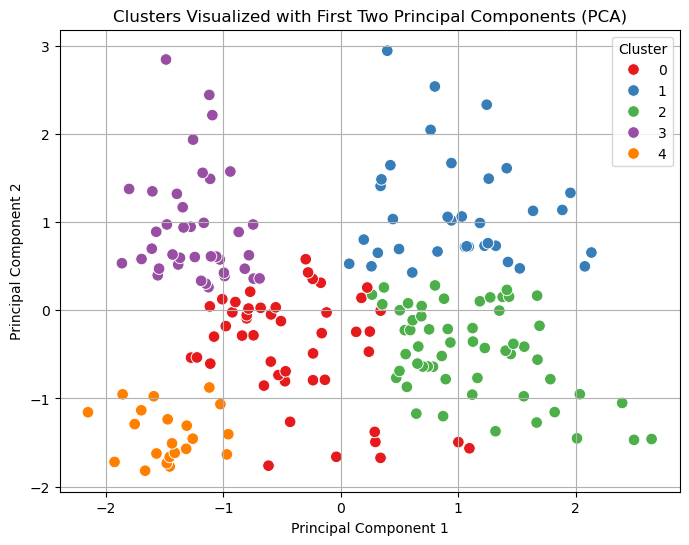

In [23]:
# Reduce to 2D for plotting
pca_2d = PCA(n_components=2)
pca_2d_components = pca_2d.fit_transform(scaled_df)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=pca_2d_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters  

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=70)
plt.title('Clusters Visualized with First Two Principal Components (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


_____________________________________________________________________
### How much variance is explained by the first two principal components?
- PC1: 44.27% of variance
- PC2: 33.31% of variance
Total for PC1 + PC2: 77.58% of the total variance in the data.

**Interpretation:** The first two PCs capture most (but not all) of the patterns in the customer data.

### How does PCA help in visualizing the clusters?
PCA helps by reducing the dataset to two dimensions while preserving most of the variance, which makes it easier to visualize patterns and cluster separations.
In this case, PCA allows us to:
- Clearly distinguish the groups formed by K-Means or Hierarchical clustering
- Understand which clusters are close or overlapping
- Simplify a high-dimensional problem into a 2D plot without losing too much information
_______________________________________________________________

## 5. Dimensionality Reduction (t-SNE)

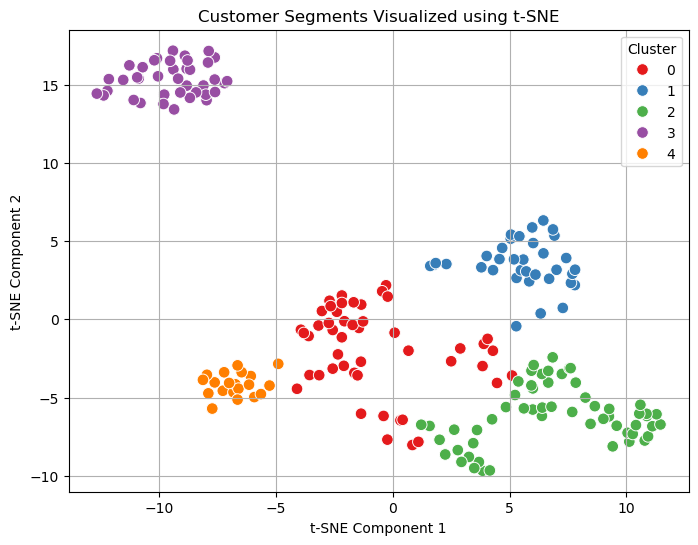

In [24]:
#from sklearn.manifold import TSNE

# Apply t-SNE (can take time depending on dataset size)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(scaled_df)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters  # use KMeans cluster labels

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', s=70)
plt.title('Customer Segments Visualized using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


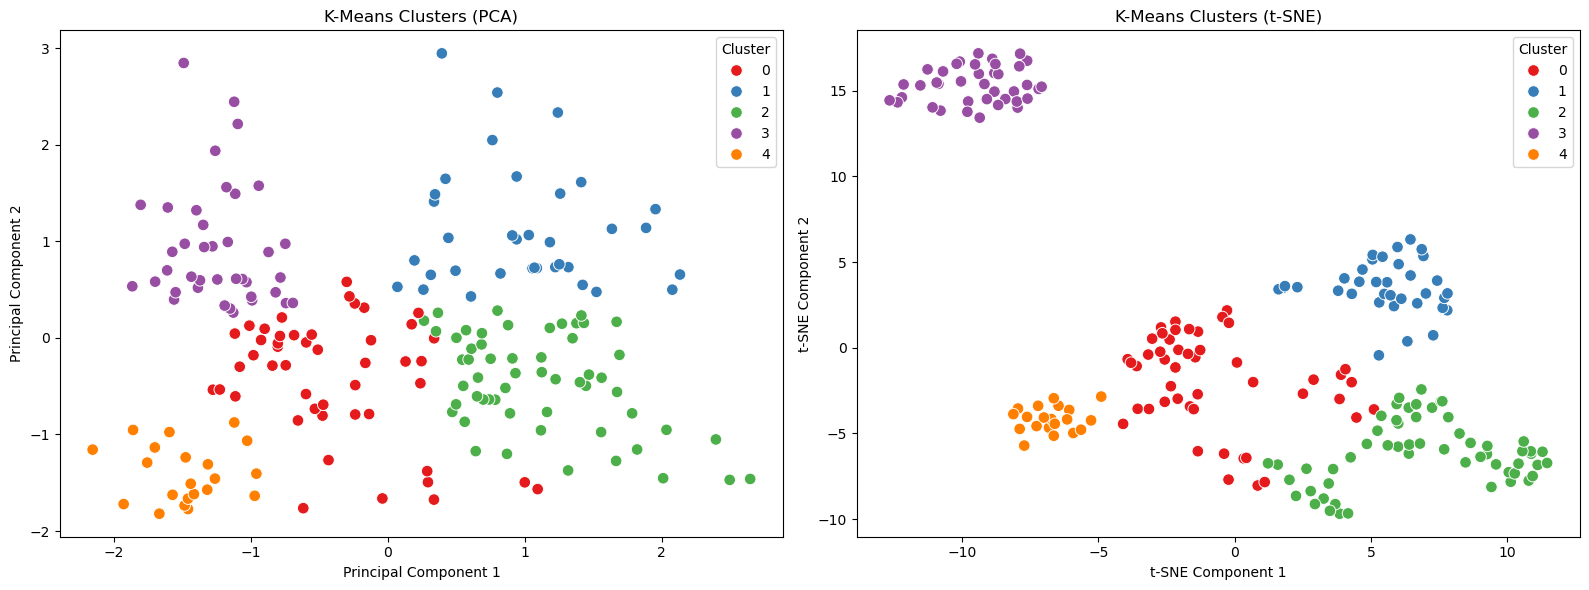

In [29]:
# Prepare DataFrames for plotting
pca_df = pd.DataFrame(pca_2d_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA Plot
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=70, ax=axes[0])
axes[0].set_title('K-Means Clusters (PCA)')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].legend(title='Cluster')

# t-SNE Plot
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', s=70, ax=axes[1])
axes[1].set_title('K-Means Clusters (t-SNE)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].legend(title='Cluster')

plt.tight_layout()
plt.show()

_______________________________________
### How does t-SNE differ from PCA in terms of visualization and cluster separation?

t-SNE and PCA differ in both their approach and the resulting visual patterns:

- PCA is a linear dimensionality reduction technique that transforms data based on variance. It aims to retain as much global structure (variance across the whole dataset) as possible. In the PCA plot (left), the clusters are visible, but there is some overlap.

- t-SNE, on the other hand, is a nonlinear technique that focuses on preserving local relationships. It emphasizes keeping nearby points close together in the lower-dimensional space. In the t-SNE plot (right), clusters are much more tightly grouped and distinctly separated, revealing underlying structures more clearly.

Thus, t-SNE offers better cluster separation for visualization purposes, especially when the actual data has complex, nonlinear relationships.
____________________________________________
### Which dimensionality reduction technique gives a clearer cluster separation?

Based on the visual comparison, t-SNE provides a clearer cluster separation than PCA.
The t-SNE plot shows five well-separated clusters with minimal overlap, making it easier to distinguish customer segments. In contrast, the PCA plot shows some intermingling between groups, which may make interpretation slightly more challenging.